In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings


# Load the dataset
file_path = 'data.csv'
df = pd.read_csv(file_path, delimiter=';')

# Define target and feature sets
target_column = 'Target'

# Define all features by type
categorical_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Previous qualification', 'Nacionality', 'Mother\'s qualification',
    'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation'
]
binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]
numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Selected features after Random Forest
selected_features = {
    'categorical': ['Course', 'Application mode'],
    'binary': ['Tuition fees up to date', 'Debtor', 'Scholarship holder'],
    'numerical': [
        'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (evaluations)',
        'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (enrolled)',
        'Admission grade', 'Curricular units 1st sem (credited)',
        'Previous qualification (grade)', 'Curricular units 1st sem (grade)'
    ]
}

# Extract full and selected feature lists
full_feature_set = categorical_features + binary_features + numerical_features
selected_feature_set = (
    selected_features['categorical'] +
    selected_features['binary'] +
    selected_features['numerical']
)

# Create a version of the dataframe with whitespace-trimmed column names
df.columns = df.columns.str.strip()

# Encode target as categorical (e.g., integer)
df[target_column] = df[target_column].astype('category').cat.codes

# Prepare to split for CV and feature sets
X_full = df[full_feature_set]
X_selected = df[selected_feature_set]
y = df[target_column]

# Set up 10-fold stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Display confirmation
{
    "X_full_shape": X_full.shape,
    "X_selected_shape": X_selected.shape,
    "y_class_distribution": y.value_counts().to_dict(),
    "num_folds": 10
}


{'X_full_shape': (4424, 36),
 'X_selected_shape': (4424, 15),
 'y_class_distribution': {2: 2209, 0: 1421, 1: 794},
 'num_folds': 10}

In [5]:
# === MAIN EXECUTION BLOCK ===
def main():
    print("Loading data...")
    df, y = load_data()
    
    # Create feature sets
    print("Creating feature sets...")
    full_feature_set = categorical_features + binary_features + numerical_features
    selected_feature_set = (
        selected_features['categorical'] +
        selected_features['binary'] +
        selected_features['numerical']
    )
    
    # Check for missing columns in the dataset
    missing_full = [col for col in full_feature_set if col not in df.columns]
    if missing_full:
        print(f"Warning: Missing columns in full feature set: {missing_full}")
        full_feature_set = [col for col in full_feature_set if col in df.columns]
        
    missing_selected = [col for col in selected_feature_set if col not in df.columns]
    if missing_selected:
        print(f"Warning: Missing columns in selected feature set: {missing_selected}")
        selected_feature_set = [col for col in selected_feature_set if col in df.columns]
    
    X_full = df[full_feature_set]
    X_selected = df[selected_feature_set]
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use 5 folds for faster runtime
    
    # Run the experiment with all three models using model-specific flows
    print("Running experiments with model-specific training flows...")
    results_df, all_results = run_model_specific_experiment(
        X_full, X_selected, y, df, skf, selected_features, 
        model_types=["dnn", "minn", "tabnet"]
    )
    
    # Save the results DataFrame to CSV for later visualization
    results_df.to_csv('model_metrics_results.csv', index=False)
    print("Results saved to 'model_metrics_results.csv'")
    
    # Calculate additional metrics for visualization
    results_df['SPD_abs'] = results_df['SPD'].abs()
    results_df['EO_abs'] = results_df['EO'].abs()
    
    # Create metrics for comparison dataframe with mean values
    summary_metrics = results_df.groupby(['model', 'feature_set', 'variant']).agg({
        'accuracy': 'mean', 
        'precision': 'mean', 
        'recall': 'mean', 
        'f1': 'mean',
        'SPD': 'mean',
        'EO': 'mean',
        'SPD_abs': 'mean',
        'EO_abs': 'mean'
    }).round(3).reset_index()
    
    # Save summary metrics for easier visualization
    summary_metrics.to_csv('summary_metrics.csv', index=False)
    print("Summary metrics saved to 'summary_metrics.csv'")
    
    # Create fairness improvement dataframe
    fairness_improvement = []
    
    for model in results_df['model'].unique():
        for feature_set in results_df['feature_set'].unique():
            baseline = summary_metrics[(summary_metrics['model'] == model) & 
                                      (summary_metrics['feature_set'] == feature_set) & 
                                      (summary_metrics['variant'] == 'baseline')]
            
            for variant in ['smote', 'adversarial']:
                variant_data = summary_metrics[(summary_metrics['model'] == model) & 
                                             (summary_metrics['feature_set'] == feature_set) & 
                                             (summary_metrics['variant'] == variant)]
                
                if not baseline.empty and not variant_data.empty:
                    baseline_spd_abs = baseline['SPD_abs'].values[0]
                    baseline_eo_abs = baseline['EO_abs'].values[0]
                    variant_spd_abs = variant_data['SPD_abs'].values[0]
                    variant_eo_abs = variant_data['EO_abs'].values[0]
                    
                    fairness_improvement.append({
                        'model': model,
                        'feature_set': feature_set,
                        'variant': variant,
                        'SPD_improvement': baseline_spd_abs - variant_spd_abs,
                        'EO_improvement': baseline_eo_abs - variant_eo_abs,
                        'baseline_accuracy': baseline['accuracy'].values[0],
                        'variant_accuracy': variant_data['accuracy'].values[0],
                        'accuracy_change': variant_data['accuracy'].values[0] - baseline['accuracy'].values[0]
                    })
    
    # Create dataframe for fairness improvement
    fairness_improvement_df = pd.DataFrame(fairness_improvement)
    fairness_improvement_df.to_csv('fairness_improvement.csv', index=False)
    print("Fairness improvement metrics saved to 'fairness_improvement.csv'")
    
    # Create feature selection impact dataframe
    feature_selection_impact = []
    
    for model in results_df['model'].unique():
        for variant in results_df['variant'].unique():
            full_data = summary_metrics[(summary_metrics['model'] == model) & 
                                       (summary_metrics['feature_set'] == 'full') & 
                                       (summary_metrics['variant'] == variant)]
            
            selected_data = summary_metrics[(summary_metrics['model'] == model) & 
                                           (summary_metrics['feature_set'] == 'selected') & 
                                           (summary_metrics['variant'] == variant)]
            
            if not full_data.empty and not selected_data.empty:
                full_spd_abs = full_data['SPD_abs'].values[0]
                full_eo_abs = full_data['EO_abs'].values[0]
                selected_spd_abs = selected_data['SPD_abs'].values[0]
                selected_eo_abs = selected_data['EO_abs'].values[0]
                
                feature_selection_impact.append({
                    'model': model,
                    'variant': variant,
                    'SPD_improvement': full_spd_abs - selected_spd_abs,
                    'EO_improvement': full_eo_abs - selected_eo_abs,
                    'full_accuracy': full_data['accuracy'].values[0],
                    'selected_accuracy': selected_data['accuracy'].values[0],
                    'accuracy_change': selected_data['accuracy'].values[0] - full_data['accuracy'].values[0]
                })
    
    # Create dataframe for feature selection impact
    feature_selection_df = pd.DataFrame(feature_selection_impact)
    feature_selection_df.to_csv('feature_selection_impact.csv', index=False)
    print("Feature selection impact metrics saved to 'feature_selection_impact.csv'")
    
    # Create accuracy-fairness trade-off dataframe
    for row in summary_metrics.itertuples():
        # Calculate trade-off score (higher is better)
        fairness_score = row.SPD_abs + row.EO_abs + 0.0001  # Add small value to avoid division by zero
        summary_metrics.loc[row.Index, 'fairness_score'] = fairness_score
        summary_metrics.loc[row.Index, 'tradeoff_score'] = row.accuracy / fairness_score
    
    # Save trade-off metrics
    summary_metrics.to_csv('tradeoff_metrics.csv', index=False)
    print("Trade-off metrics saved to 'tradeoff_metrics.csv'")
    
    # Display results with focus on fairness metrics
    print("\nResults Summary:")
    summary = results_df.groupby(['model', 'feature_set', 'variant']).mean().round(3)
    print(summary)
    
    # Print focused fairness metrics analysis
    print("\nFairness Metrics Analysis (Gender: 0=female, 1=male):")
    fairness_metrics = ['SPD', 'EO']
    fairness_summary = summary[fairness_metrics]
    
    print("\nStatistical Parity Difference (SPD):")
    print("- Negative values indicate bias against females (less likely to be predicted as dropouts)")
    print("- Positive values indicate bias against males (more likely to be predicted as dropouts)")
    print(fairness_summary['SPD'].unstack().round(3))
    
    print("\nEqualized Opportunity (EO):")
    print("- Positive values indicate model is better at identifying female dropouts")
    print("- Negative values indicate model is better at identifying male dropouts")
    print(fairness_summary['EO'].unstack().round(3))
    
    return results_df, all_results, summary_metrics, fairness_improvement_df, feature_selection_df

if __name__ == "__main__":
    try:
        import torch
        print("PyTorch is available for TabNet.")
    except (ImportError, ModuleNotFoundError):
        print("PyTorch is not available. TabNet will use fallback model.")
    
    try:
        import tensorflow as tf
        print(f"TensorFlow is available for MINN. Version: {tf.__version__}")
    except (ImportError, ModuleNotFoundError):
        print("TensorFlow is not available. MINN will use fallback model.")
    
    # Run the main function and get all dataframes
    results_df, all_results, summary_metrics, fairness_improvement_df, feature_selection_df = main()

PyTorch is available for TabNet.
TensorFlow is available for MINN. Version: 2.19.0
Loading data...
Creating feature sets...
Running experiments with model-specific training flows...

Processing full feature set...
  Fold 1/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_accuracy = 0.75932

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_accuracy = 0.73672

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_accuracy = 0.7661
  Fold 2/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_accuracy = 0.77175

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_accuracy = 0.73333

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_accuracy = 0.7661
  Fold 3/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occu

<Figure size 2000x1000 with 0 Axes>

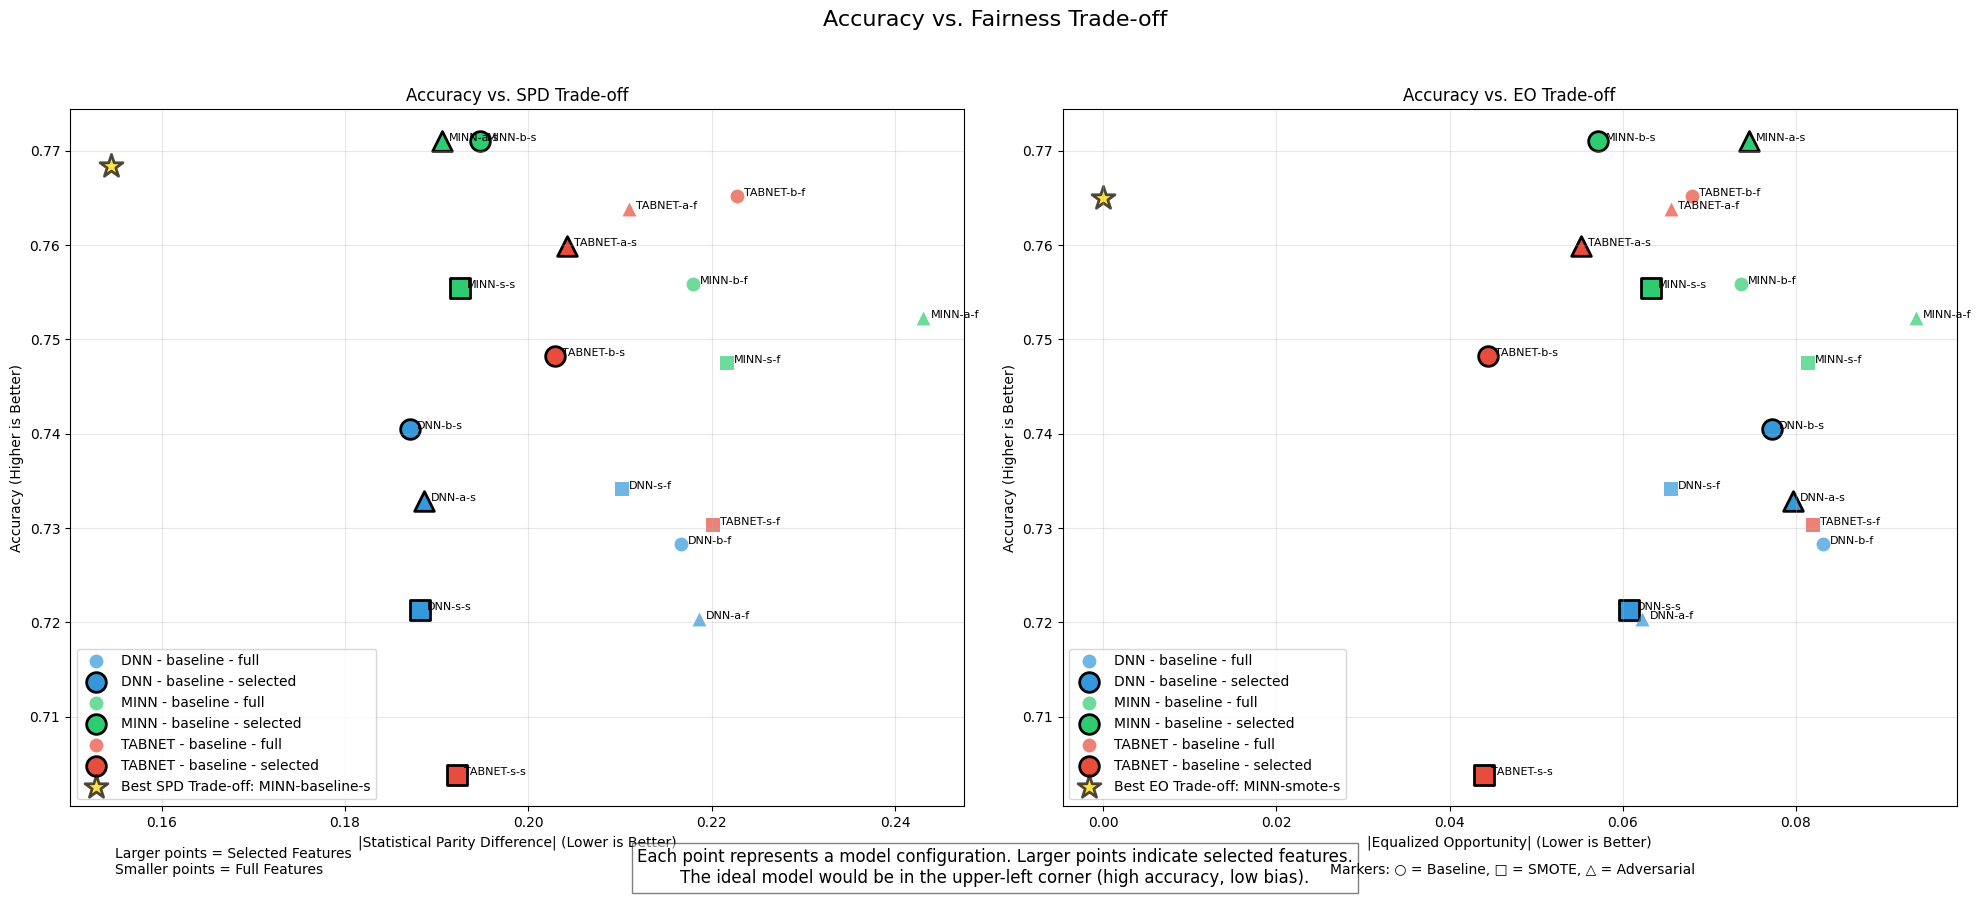

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create fairness-accuracy tradeoff visualization
plt.figure(figsize=(20, 10))

# Create subplots for SPD and EO trade-offs
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Accuracy vs. Fairness Trade-off', fontsize=16)

# Set up colors, markers, and sizes
models = ['dnn', 'minn', 'tabnet']
variants = ['baseline', 'smote', 'adversarial']
feature_sets = ['full', 'selected']
colors = {'dnn': '#3498db', 'minn': '#2ecc71', 'tabnet': '#e74c3c'}
markers = {'baseline': 'o', 'smote': 's', 'adversarial': '^'}
sizes = {'full': 100, 'selected': 200}
alphas = {'full': 0.7, 'selected': 1.0}

# Calculate absolute values of fairness metrics
results_df['SPD_abs'] = results_df['SPD'].abs()
results_df['EO_abs'] = results_df['EO'].abs()

# 1. Accuracy vs. SPD Trade-off
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_spd_abs = subset['SPD_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                axes[0].scatter(
                    mean_spd_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=colors[model], 
                    marker=markers[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                axes[0].annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_spd_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=8
                )

# 2. Accuracy vs. EO Trade-off
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_eo_abs = subset['EO_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                axes[1].scatter(
                    mean_eo_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=colors[model], 
                    marker=markers[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                axes[1].annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_eo_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=8
                )

# Highlight the best models (upper-left corner is ideal)
# Find the model with best accuracy/fairness trade-off
best_tradeoff = results_df.copy()
best_tradeoff['spd_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['SPD_abs'] + 0.0001)
best_tradeoff['eo_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['EO_abs'] + 0.0001)

best_spd = best_tradeoff.loc[best_tradeoff['spd_tradeoff'].idxmax()]
best_eo = best_tradeoff.loc[best_tradeoff['eo_tradeoff'].idxmax()]

axes[0].scatter(
    best_spd['SPD_abs'], best_spd['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best SPD Trade-off: {best_spd['model'].upper()}-{best_spd['variant']}-{best_spd['feature_set'][0]}"
)

axes[1].scatter(
    best_eo['EO_abs'], best_eo['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best EO Trade-off: {best_eo['model'].upper()}-{best_eo['variant']}-{best_eo['feature_set'][0]}"
)

# Add formatting to the SPD plot
axes[0].set_xlabel('|Statistical Parity Difference| (Lower is Better)')
axes[0].set_ylabel('Accuracy (Higher is Better)')
axes[0].set_title('Accuracy vs. SPD Trade-off')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='lower left')

# Add formatting to the EO plot
axes[1].set_xlabel('|Equalized Opportunity| (Lower is Better)')
axes[1].set_ylabel('Accuracy (Higher is Better)')
axes[1].set_title('Accuracy vs. EO Trade-off')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='lower left')

# Add annotations
plt.figtext(0.5, 0.01, 
           'Each point represents a model configuration. Larger points indicate selected features.\n'
           'The ideal model would be in the upper-left corner (high accuracy, low bias).',
           ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Add mini-legend explaining point size and transparency
plt.figtext(0.06, 0.02, 
           'Larger points = Selected Features\nSmaller points = Full Features',
           ha='left', fontsize=10)

# Add mini-legend explaining markers
marker_legend = "Markers: ○ = Baseline, □ = SMOTE, △ = Adversarial"
plt.figtext(0.85, 0.02, 
           marker_legend,
           ha='right', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('accuracy_fairness_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/xc/nd4v5ylx1yd__4ycnb6lz7dc0000gn/T/ipykernel_31380/2416918238.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Gender', y='Count', data=gender_counts, palette=colors,width=0.6)


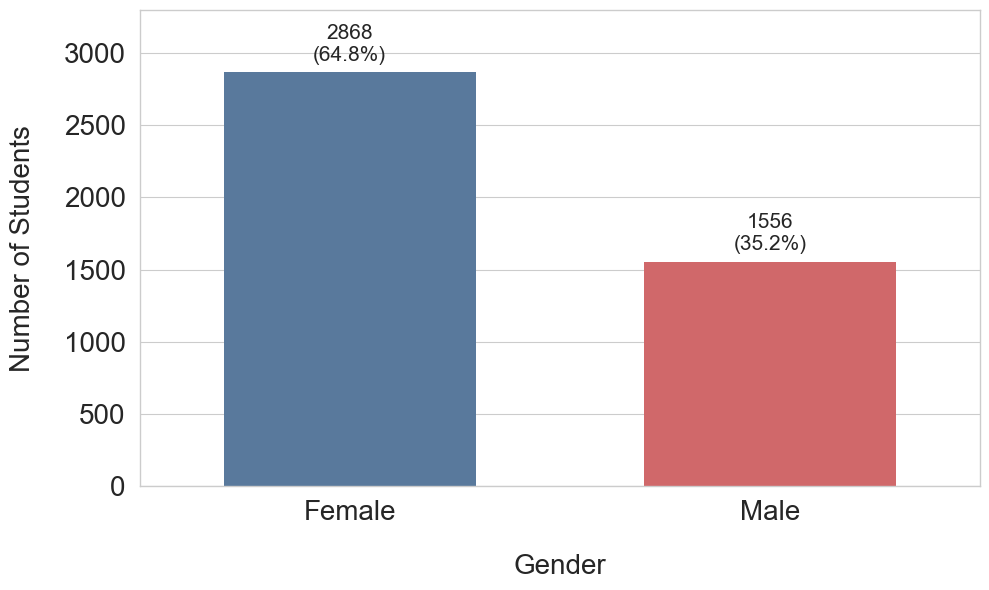

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Unified color scheme
MODEL_COLORS = {
    'dnn': '#4e79a7',    # Blue
    'minn': '#59a14f',   # Green
    'tabnet': '#e15759'  # Red
}

# Set text sizes
TITLE_SIZE = 16
AXIS_LABEL_SIZE = 20
TICK_LABEL_SIZE = 20
VALUE_LABEL_SIZE = 15
ANNOTATION_SIZE = 20
VALUE_LABEL_SIZE = 15



# Create figure
plt.figure(figsize=(10, 6))

# Count gender distribution
gender_counts = df['Gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

# Map numeric gender values to labels
gender_counts['Gender'] = gender_counts['Gender'].map({0: 'Female', 1: 'Male'})

# Calculate percentages
total = gender_counts['Count'].sum()
gender_counts['Percentage'] = (gender_counts['Count'] / total * 100).round(1)

# Create the plot with the unified color scheme
colors = [MODEL_COLORS['dnn'], MODEL_COLORS['tabnet']]  # Blue, Red for gender
ax = sns.barplot(x='Gender', y='Count', data=gender_counts, palette=colors,width=0.6)

# Add count and percentage labels on top of bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    label = f"{int(height)}\n({gender_counts['Percentage'].iloc[i]}%)"
    ax.text(p.get_x() + p.get_width()/2., height + 50, label,
            ha="center", va="bottom", fontsize=VALUE_LABEL_SIZE)

# Add titles and labels
plt.xlabel('Gender', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('Number of Students', fontsize=AXIS_LABEL_SIZE)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
plt.ylim(0, gender_counts['Count'].max() * 1.15)  # Add space for labels

plt.tight_layout()
plt.show()

/var/folders/xc/nd4v5ylx1yd__4ycnb6lz7dc0000gn/T/ipykernel_31380/3225315721.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Target', y='Count', data=target_counts, palette=colors[:len(target_counts)])


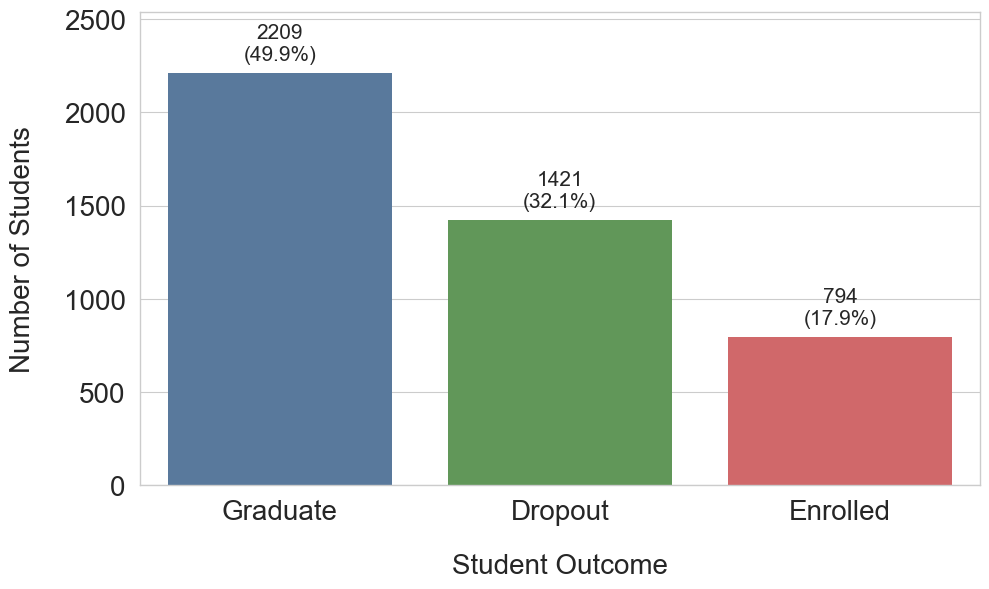

In [73]:
# Create figure
plt.figure(figsize=(10, 6))

# Get the target column name
target_column = [col for col in df.columns if 'Target' in col][0]

# Count target distribution
target_counts = df[target_column].value_counts().reset_index()
target_counts.columns = ['Target', 'Count']

# Map numeric target values to labels
target_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
if len(target_counts) <= 3:  # Check if we have 3 or fewer classes
    target_counts['Target'] = target_counts['Target'].map(
        lambda x: target_mapping.get(x, f'Class {x}')
    )

# Calculate percentages
total = target_counts['Count'].sum()
target_counts['Percentage'] = (target_counts['Count'] / total * 100).round(1)

# Create plot with unified color scheme
colors = list(MODEL_COLORS.values())  # Use the model colors for target classes
ax = sns.barplot(x='Target', y='Count', data=target_counts, palette=colors[:len(target_counts)])

# Add count and percentage labels on top of bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    label = f"{int(height)}\n({target_counts['Percentage'].iloc[i]}%)"
    ax.text(p.get_x() + p.get_width()/2., height + 50, label,
            ha="center", va="bottom", fontsize=VALUE_LABEL_SIZE)

# Add titles and labels
plt.xlabel('Student Outcome', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('Number of Students', fontsize=AXIS_LABEL_SIZE)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
plt.ylim(0, target_counts['Count'].max() * 1.15)  # Add space for labels

plt.tight_layout()
plt.show()

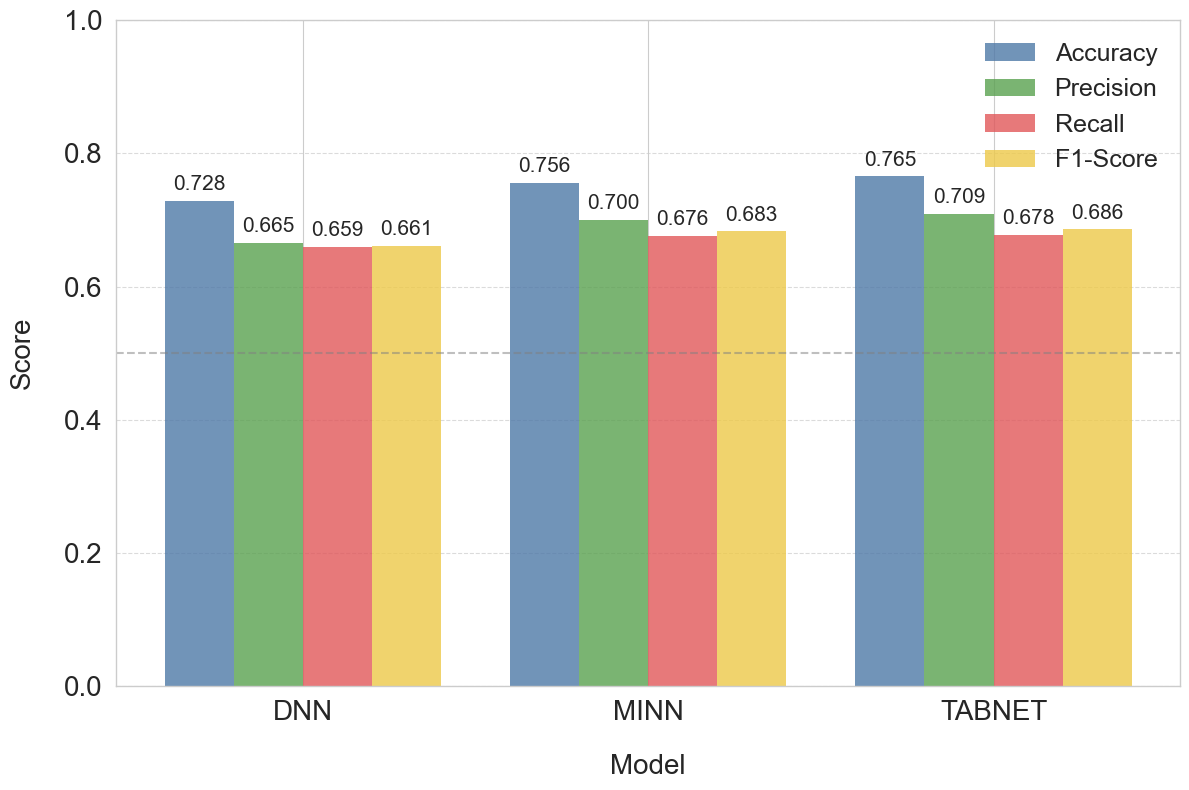

In [79]:
# Metric colors
METRIC_COLORS = {
    'accuracy': '#4e79a7',   # Blue
    'precision': '#59a14f',  # Green
    'recall': '#e15759',     # Red
    'f1': '#edc949'          # Yellow
}

# Filter for baseline models with full features
baseline_full = results_df[(results_df['variant'] == 'baseline') & 
                          (results_df['feature_set'] == 'full')]

# Create figure
plt.figure(figsize=(12, 8))

# Define metrics and their labels
performance_metrics = ['accuracy', 'precision', 'recall', 'f1']
pretty_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Calculate means for each model and metric
model_means = baseline_full.groupby('model')[performance_metrics].mean()

# Define bar positions and width
bar_width = 0.2
x = np.arange(len(model_means.index))

# Plot each performance metric as a group of bars
for i, metric in enumerate(performance_metrics):
    bars = plt.bar(x + (i - 1.5) * bar_width, model_means[metric], 
           width=bar_width, label=pretty_labels[i], 
           color=METRIC_COLORS[metric], alpha=0.8)
    
    # Add value labels on top of bars
    for j, value in enumerate(model_means[metric]):
        plt.text(x[j] + (i - 1.5) * bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=VALUE_LABEL_SIZE)

# Add labels and title
plt.xlabel('Model', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('Score', fontsize=AXIS_LABEL_SIZE)
plt.xticks(x, [model.upper() for model in model_means.index], 
          fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
plt.legend(fontsize=18)
plt.ylim(0, 1.0)  # Set y-axis limit from 0 to 1

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y=0.5 for reference
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

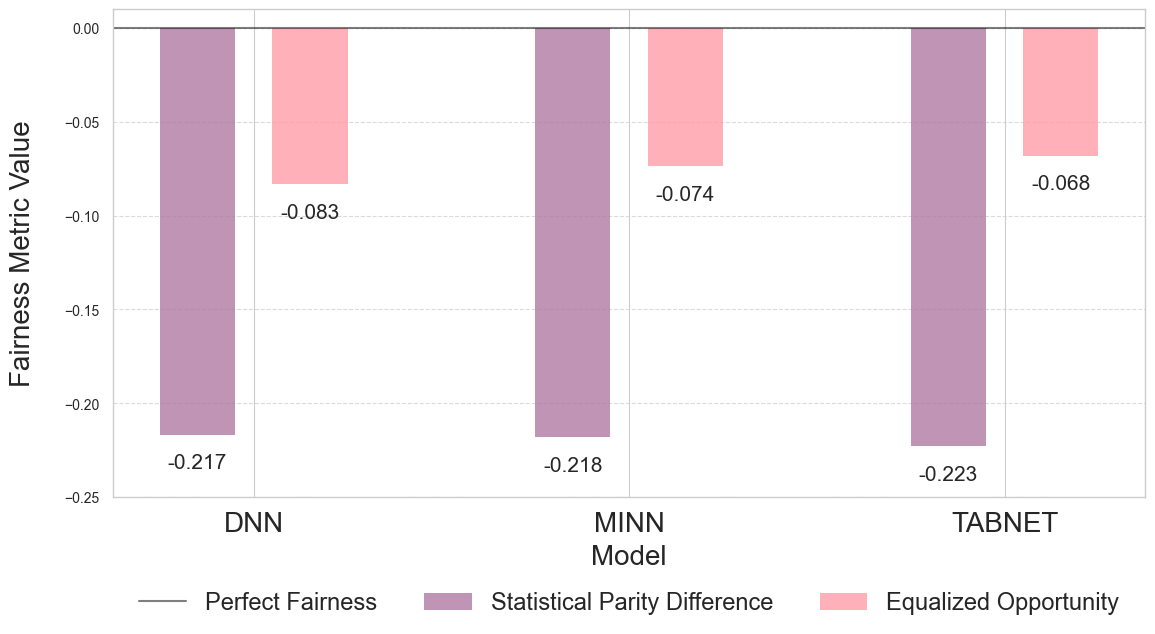

In [83]:
# Fairness colors
FAIRNESS_COLORS = {
    'SPD': '#af7aa1',    # Purple
    'EO': '#ff9da7'      # Pink
}

# Filter for baseline models with full features
baseline_full = results_df[(results_df['variant'] == 'baseline') & 
                          (results_df['feature_set'] == 'full')]

# Create figure
plt.figure(figsize=(12, 8))

# Define fairness metrics
fairness_metrics = ['SPD', 'EO']
pretty_fairness_labels = ['Statistical Parity Difference', 'Equalized Opportunity']

# Calculate means for each model and fairness metric
fairness_means = baseline_full.groupby('model')[fairness_metrics].mean()

# Make bar width narrower and adjust positions
bar_width = 0.2  # Even narrower
bar_positions = [-0.15, 0.15]  # Move bars further apart

# Plot each fairness metric
for i, metric in enumerate(fairness_metrics):
    bars = plt.bar(x + bar_positions[i], fairness_means[metric], 
                  width=bar_width, label=pretty_fairness_labels[i], 
                  color=FAIRNESS_COLORS[metric], alpha=0.8)
    
    # Add value labels on top/bottom of bars
    for j, bar in enumerate(bars):
        value = fairness_means[metric].iloc[j]
        # Position text above or below bar depending on value
        if value < 0:
            va = 'top'
            offset = -0.01
        else:
            va = 'bottom'
            offset = 0.01
            
        plt.text(bar.get_x() + bar.get_width() / 2, value + offset, 
                f'{value:.3f}', ha='center', va=va, 
                fontsize=VALUE_LABEL_SIZE)

# Add a horizontal line at y=0 for perfect fairness
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect Fairness')

# Add labels and title
plt.xlabel('Model', fontsize=AXIS_LABEL_SIZE,labelpad=5)
plt.ylabel('Fairness Metric Value', fontsize=AXIS_LABEL_SIZE)
# plt.title('Fairness Metrics for Baseline Models (Full Features)', fontsize=TITLE_SIZE)
plt.xticks(x, [model.upper() for model in fairness_means.index], 
          fontsize=TICK_LABEL_SIZE)

# Move legend outside the plot area to the bottom
plt.legend(fontsize=17, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust Y-axis limits to leave space at the top
y_min = min(fairness_means.min().min() * 1.1, -0.25)  # At least -0.25 or 10% below minimum
plt.ylim(y_min, 0.01)  # Small positive value to have space at the top

'''
# Add annotation explaining fairness metrics
plt.figtext(0.5, 0.01, 
           'Statistical Parity Difference (SPD): Negative values indicate bias against females (less likely to be predicted as dropouts)\n'
           'Equalized Opportunity (EO): Negative values indicate model is better at identifying male dropouts than female dropouts\n'
           'Values closer to zero indicate more fair predictions.',
           ha='center', fontsize=10, 
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
'''

plt.tight_layout(rect=[0, 0.15, 1, 0.98])  # Adjust for annotation and legend
plt.show()

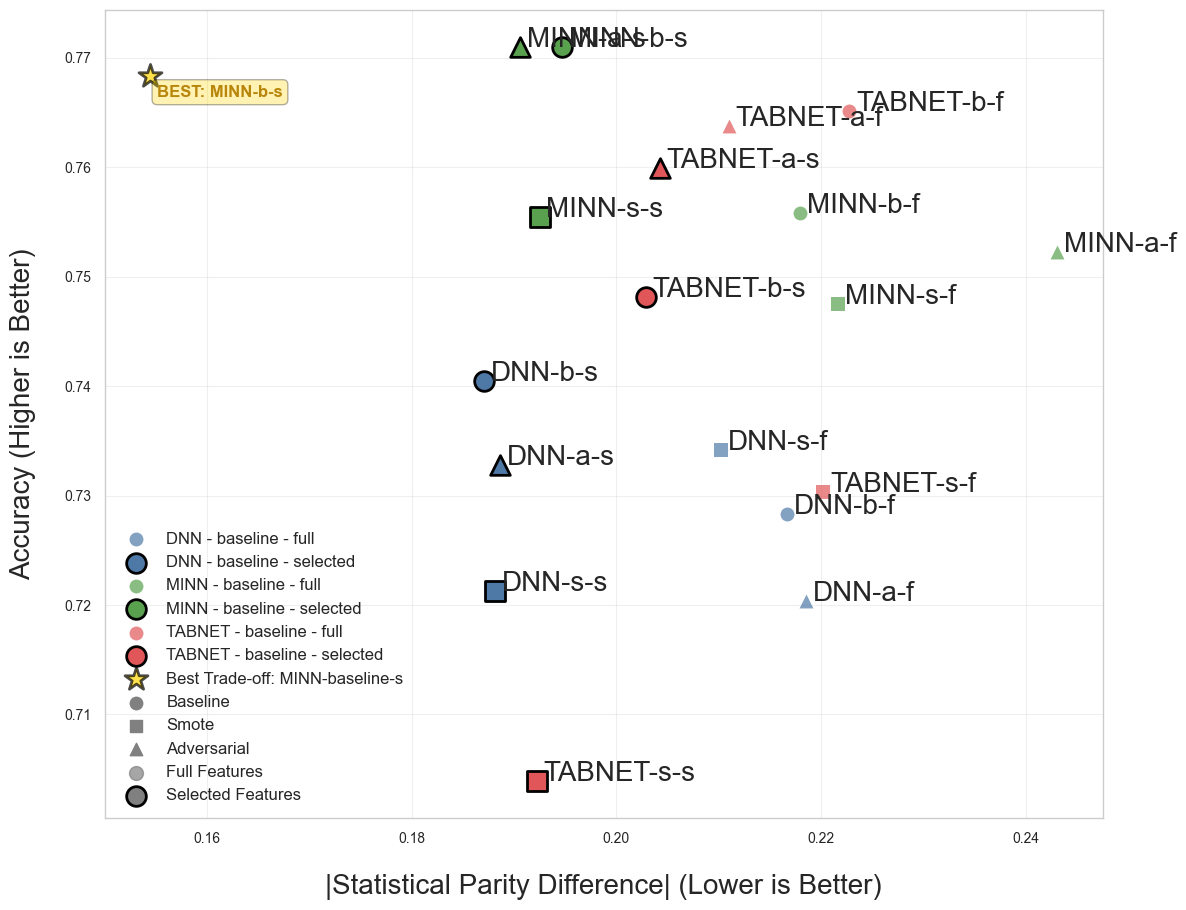

In [89]:
# Variant markers
VARIANT_MARKERS = {
    'baseline': 'o',     # Circle
    'smote': 's',        # Square
    'adversarial': '^'   # Triangle
}

# Calculate absolute values of fairness metrics
results_df['SPD_abs'] = results_df['SPD'].abs()

# Create figure
plt.figure(figsize=(12, 10))

# Set up sizes and alphas
models = ['dnn', 'minn', 'tabnet']
variants = ['baseline', 'smote', 'adversarial']
feature_sets = ['full', 'selected']
sizes = {'full': 100, 'selected': 200}
alphas = {'full': 0.7, 'selected': 1.0}

# Plot each model configuration
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_spd_abs = subset['SPD_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                plt.scatter(
                    mean_spd_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=MODEL_COLORS[model], 
                    marker=VARIANT_MARKERS[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                plt.annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_spd_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=ANNOTATION_SIZE
                )

# Find best model for SPD trade-off
best_tradeoff = results_df.copy()
best_tradeoff['spd_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['SPD_abs'] + 0.0001)
best_spd = best_tradeoff.loc[best_tradeoff['spd_tradeoff'].idxmax()]

# Highlight the best model
plt.scatter(
    best_spd['SPD_abs'], best_spd['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best Trade-off: {best_spd['model'].upper()}-{best_spd['variant']}-{best_spd['feature_set'][0]}"
)

# Add text annotation for the best model
plt.annotate(
    f"BEST: {best_spd['model'].upper()}-{best_spd['variant'][0]}-{best_spd['feature_set'][0]}",
    (best_spd['SPD_abs'], best_spd['accuracy']),
    textcoords="offset points",
    xytext=(5, -15),  # Position text below the star
    fontsize=12,
    fontweight='bold',
    color='darkgoldenrod',
    bbox=dict(boxstyle="round,pad=0.3", fc="gold", alpha=0.3)
)

# Add markers legend (add these to the legend)
# Create dummy scatter points that won't be shown but will appear in legend
for variant, marker in VARIANT_MARKERS.items():
    plt.scatter([], [], marker=marker, color='gray', 
               label=f"{variant.capitalize()}", s=80)

# Add labels and formatting
plt.xlabel('|Statistical Parity Difference| (Lower is Better)', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('Accuracy (Higher is Better)', fontsize=AXIS_LABEL_SIZE)
plt.grid(True, alpha=0.3)

# Size legend entries
plt.scatter([], [], s=100, color='gray', alpha=0.7, label="Full Features")
plt.scatter([], [], s=200, color='gray', alpha=1.0, edgecolor='black', linewidth=2, label="Selected Features")

# Create the legend with all elements
plt.legend(fontsize=12, loc='lower left', scatterpoints=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

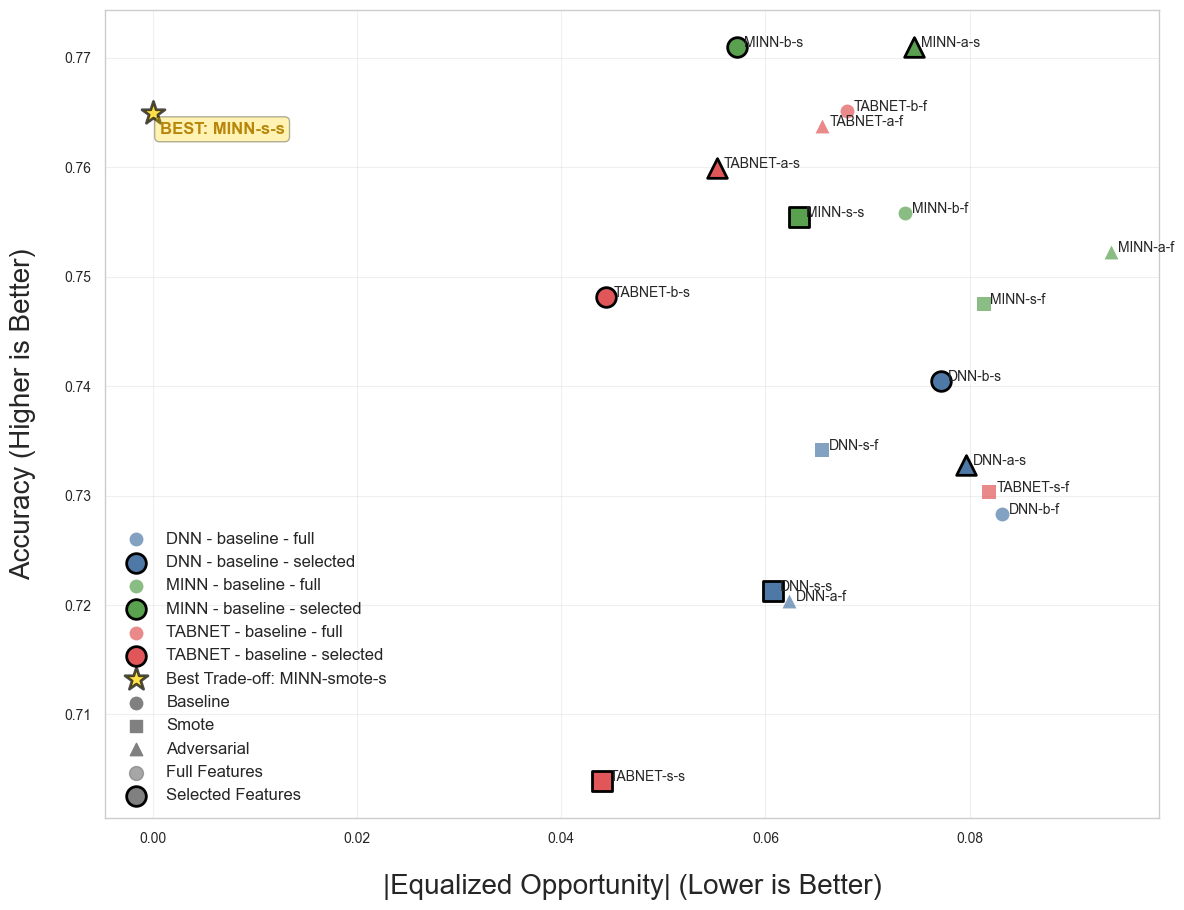

In [91]:
# Calculate absolute values of fairness metrics
results_df['EO_abs'] = results_df['EO'].abs()

# Create figure
plt.figure(figsize=(12, 10))

# Plot each model configuration
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_eo_abs = subset['EO_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                plt.scatter(
                    mean_eo_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=MODEL_COLORS[model], 
                    marker=VARIANT_MARKERS[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                plt.annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_eo_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=10
                )

# Find best model for EO trade-off
best_tradeoff = results_df.copy()
best_tradeoff['eo_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['EO_abs'] + 0.0001)
best_eo = best_tradeoff.loc[best_tradeoff['eo_tradeoff'].idxmax()]

# Highlight the best model
plt.scatter(
    best_eo['EO_abs'], best_eo['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best Trade-off: {best_eo['model'].upper()}-{best_eo['variant']}-{best_eo['feature_set'][0]}"
)

# Add text annotation for the best model
plt.annotate(
    f"BEST: {best_eo['model'].upper()}-{best_eo['variant'][0]}-{best_eo['feature_set'][0]}",
    (best_eo['EO_abs'], best_eo['accuracy']),
    textcoords="offset points",
    xytext=(5, -15),  # Position text below the star
    fontsize=12,
    fontweight='bold',
    color='darkgoldenrod',
    bbox=dict(boxstyle="round,pad=0.3", fc="gold", alpha=0.3)
)

# Add markers legend (add these to the legend)
# Create dummy scatter points that won't be shown but will appear in legend
for variant, marker in VARIANT_MARKERS.items():
    plt.scatter([], [], marker=marker, color='gray', 
               label=f"{variant.capitalize()}", s=80)

# Add labels and formatting
plt.xlabel('|Equalized Opportunity| (Lower is Better)', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('Accuracy (Higher is Better)', fontsize=AXIS_LABEL_SIZE)
plt.grid(True, alpha=0.3)

# Size legend entries
plt.scatter([], [], s=100, color='gray', alpha=0.7, label="Full Features")
plt.scatter([], [], s=200, color='gray', alpha=1.0, edgecolor='black', linewidth=2, label="Selected Features")

# Create the legend with all elements
plt.legend(fontsize=12, loc='lower left', scatterpoints=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()